# Midterm (MACS 30100), February 5, 2018
### Xiuyuan Zhang
You will have an hour and thirty minutes to take this exam.
1. Put your name in the space provided above (without the brackets).
2. Download this notebook and accompanying data `LenderDataLong.dta`.
3. The class will disconnect their wi-fi and begin taking the exam.
4. The exam is open computer, closed internet, open note.
5. Once you are done, you will signal to a TA or instructor to come over and monitor while you reconnect to the internet and upload your edited notebook to Canvas.

Remember that you must clearly indicate your answers to all questions below. We will give partial credit for partially correct answers. The midterm is worth 20 points (2 problem sets).

## The data
This two exercises of this midterm and all their respective subparts will use the `LenderData.csv` dataset, which contains observations of characteristics on short-term, high interest rate, lender information. You are not to use this data outside of this class. It is a jittered and randomized version of a dataset used in a published research paper.

Each observation contains characteristics of a particular lender location Read it into Python using the `pandas.read_csv()` command. The variables are the following:

* `avgrate`: average annualized interest rate of all loans in percentage points (235 = two hundred and thirty five percent)
* `numstores`: number of other stores owned by the same owner (measure of size)
* `defrate`: default rate on loans from that store during 2010
* `pdrad3`: number of payday lenders within a three-mile radius of the store (measure of competition)
* `pnrad3`: number of pawn lenders within a three-mile radius of the store (measure of competition)
* `totrad3`: total number of other lenders within a three-mile radius of the store (measure of competition)
* `unrt_zip`: unemployment rate in the zip code of the store
* `medtotinc2010`: median total household income in the zip code of the store
* `edbachplus_zip`: average education level in years of schooling of heads of household in the zip code of the store
* `pop_zip`: population in zip code of the store
* `mdage_zip`: median age (in years) in zip code of the store
* `pctblk2_zip`: percent of the population that is black in the zip code of the store in percentage points (2.2=two point two percent)

In [137]:
# import Python liberaries
import numpy as np
import numpy.linalg as lin

import scipy
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as intgr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas.plotting import scatter_matrix

import sklearn as sk
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import statsmodels.api as sm

%matplotlib inline

In [138]:
# Read in the data
data_lender = pd.read_csv("LenderData.csv")

In [139]:
data_lender.head()

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7


## 1. Using the distributions of interest rates and median income (10 points)

1A) [2 points] Create a plot of the histogram of high interest rate lenders interest rates `avgrate`. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into $N$ categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

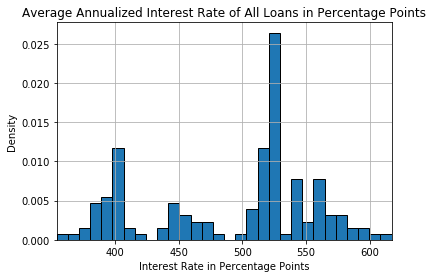

1A: I would group the lenders into three categories, since the histogram shows the data to be multimodal and have three differentpeaks around 400, 450 and 525. Thus, I will group the data according to these three clusters.


In [140]:
# plot the histogram
plt.hist(data_lender["avgrate"], bins = 30, edgecolor ='black', normed = True)
plt.xlim(min(data_lender["avgrate"]), max(data_lender["avgrate"]))

plt.title('Average Annualized Interest Rate of All Loans in Percentage Points')
plt.ylabel('Density')
plt.xlabel('Interest Rate in Percentage Points')
plt.grid(True)

plt.show()

print("1A: I would group the lenders into three categories, since the histogram shows the data to be multimodal and have three different" +
      "peaks around 400, 450 and 525. Thus, I will group the data according to these three clusters.")

1B) [1 point] Create a plot of the histogram of median total household income `medtotinc2010`. Use 30 bins. Make sure to label your axes and give the figure a title.

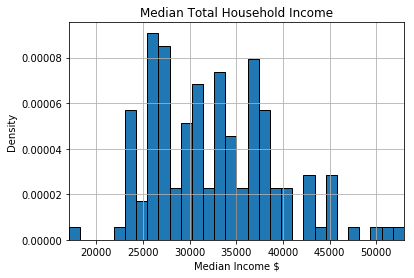

In [141]:
# plot the histogram
plt.hist(data_lender["medtotinc2010"], bins = 30, edgecolor ='black', normed = True)
plt.xlim(min(data_lender["medtotinc2010"]), max(data_lender["medtotinc2010"]))

plt.title('Median Total Household Income')
plt.ylabel('Density')
plt.xlabel('Median Income $')
plt.grid(True)

plt.show()

1C) [5 points] Use maximum likelihood estimation to fit a lognormal distribution $LN(\mu, \sigma)$ to the median income data `medtotinc2010`. Report your estimated $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$. Report the standard error on the estimate for $\hat{\mu}_{mle}$.

In [142]:
# write functions
def calculate_pdf(xvals, mu, sigma):
    '''
    Calculate log normal distribution.
    
    Inputs: xvals(numpy array)
            mu (float): mean
            sigma (float): standard deviation
            
    Returns: pdf_vals(numpy array)
    '''
    prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                prob_notcut)
    
    return pdf_vals

def calculate_log_lik(xvals, mu, sigma):
    '''
    Calculate log likelihood.
    
    Inputs: xvals(numpy array)
            mu(float): mean
            sigma(float): standard deviation
    Returns: log_pdf_vals(float)
    '''
       
    pdf_vals = calculate_pdf(xvals, mu, sigma)
    log_pdf_vals = np.log(pdf_vals).sum()
        
    return log_pdf_vals

def crit(params, data):
    '''
    Computes the negative of the log likelihood function
    given parameters and data for minimization.
    
    Inputs: params(list): two floats, mu and sigma
            data
    Returns: neg_log_lik_val(float)
    '''
    mu, sigma = params
    log_lik_val = calculate_log_lik(data, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val


In [143]:
params_init = np.array([11, 0.5])
results = opt.minimize(crit, params_init, data_lender["medtotinc2010"], method='L-BFGS-B',
                       bounds = ((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
log_lik_val = calculate_log_lik(data_lender["medtotinc2010"], mu_MLE, sig_MLE)

OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])

print('The ML estimates for mu is', mu_MLE, 'and for sigma is', sig_MLE)
print('')
print('The value of the likelihood function is', log_lik_val)
print('')
print('The variance-covariance matrix is', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)

The ML estimates for mu is 10.3773800497 and for sigma is 0.199499395601

The value of the likelihood function is -1497.10300889

The variance-covariance matrix is [[  2.59981524e-04  -7.69592181e-06]
 [ -7.69592181e-06   1.28943995e-04]]
Standard error for mu estimate =  0.0161239425589


1D) [2 points] Plot the predicted distribution from your maximum likelihood estimates $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ against the histogram of the data.

## 2. Determinants of lender interest rates (10 points)

2A) [3 points] Assume a simple regression model of four factors that influence the interest rates that a lender charges, namely, number of stores, default rate in the area, unemployment rate in the area, and median household income in the area.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + u_i $$

Estimate this model by OLS using the `statsmodels.api` package. Don't forget to include a constant. Print your results summary. Which variables are significant at the 5-percent level? How would you interpret in words the estimated coefficient on `numstores`?

In [144]:
data_lender["constant"] = 1

reg_avg = sm.OLS(endog = data_lender.avgrate, exog = data_lender[['constant', 'numstores', 'defrate',
                                                                    'unrt_zip', 'medtotinc2010']], missing = 'drop')
results_avg = reg_avg.fit()
print(results_avg.summary())


                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.375
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00229
Time:                        13:09:44   Log-Likelihood:                -812.28
No. Observations:                 147   AIC:                             1635.
Df Residuals:                     142   BIC:                             1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        453.4117     51.263      8.845

2A Answer: The variables $numstores$ and the $constant$ are significant at the 5% level. The $numstores$ has a p-value of 0.000 and the $constant$ also has a p-value of 0.000. The estimated coefficient for $numstores$ is -2.6278. This value suggests that a positive increase of $numstores$ negatively influence the variable $avgrate$. An increase of 1 in $numstores$ lead to a -2.6278 decrease in $avgrate$.

2B) [4 points] Now assume a richer model for the determinants of lender interest rates, which includes the following measures of competition and other demographic variables.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + ... $$
$$ \qquad\qquad\qquad\qquad \beta_5 totrad3_i + \beta_6 edbachplus\_zip_i + \beta_7 pop\_zip_i + \beta_8 mdage\_zip_i + \beta_9 pctblk2\_zip_i + u_i $$

Estimate this regression by OLS using the `statsmodels.api` package. In controlling for these new varaibles, do any of the originally estimated coefficients from the model in part (2A) become statistically not significant (at the 5 percent level)? Of these new coefficients ($\beta_5$ through $\beta_9$), which one(s) are the most statistically significant?

In [145]:
reg_avg_rich = sm.OLS(endog = data_lender.avgrate, exog = data_lender[['constant', 'numstores', 'defrate',
                                                                    'unrt_zip', 'medtotinc2010', 'totrad3',
                                                                 'edbachplus_zip', 'pop_zip', 'mdage_zip',
                                                                 'pctblk2_zip']], missing = 'drop')
results_avg_rich = reg_avg_rich.fit()
print(results_avg_rich.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.846
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00419
Time:                        13:09:48   Log-Likelihood:                -808.23
No. Observations:                 147   AIC:                             1636.
Df Residuals:                     137   BIC:                             1666.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
constant         613.9741     85.491      7.

**2B Answer: ** No, in this new estimation, the $numstores$ variable is still statistically significant with a p-value of 0.000. Of the new varianbles added, variable $edbachplus_zip$ is the most statistically significant with a p-vale of 0.047.

2C) [3 points] Create a new binary variable called `avgrate_high` that equals 1 if `avgrate` > 490, and equals 0 otherwise. Estimate a logistic regression using the `statsmodels.api` package. Let $X\beta$ be the linear coefficients and variables from the model from part (2B).

$$ Pr(avgrate\_high=1|X\beta) = \frac{X\beta}{1 + X\beta} $$

Report the variables whose coefficients are estimated to be significant at the 5-percent level.

In [146]:
data_lender['avgrate_high'] = data_lender['avgrate'].apply(lambda x: 1 if x >= 425 else 0)
data_lender.head()

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip,constant,avgrate_high
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0,1,1
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4,1,1
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7,1,1


In [147]:
logit_reg = sm.Logit(data_lender['avgrate_high'], data_lender[['constant', 'numstores', 'defrate',
                                                                'unrt_zip', 'medtotinc2010','edbachplus_zip', 'pop_zip', 
                                                               'mdage_zip','pctblk2_zip']], missing = "drop")
results_logit = logit_reg.fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.324112
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           avgrate_high   No. Observations:                  147
Model:                          Logit   Df Residuals:                      138
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                  0.4095
Time:                        13:09:53   Log-Likelihood:                -47.644
converged:                       True   LL-Null:                       -80.685
                                        LLR p-value:                 2.950e-11
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
constant           8.2300      4.933      1.668      0.095      -1.439      17.899
numstores        

**2 C Answer:** The variables $numstores$ and $defrate$ are statistically significant with p-value of 0.000 and 0.009 at the 5-percent level.